In [4]:
#!/usr/bin/env python
import sys
sys.path.append('/home/carol/repos/emg-regression')

import pickle
import torch
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from emg_regression.utils.data_processing import Data_processing
from emg_regression.utils.trainer import Trainer
from emg_regression.utils.model_tools import *
from emg_regression.approximators.lstm import LSTM

# Parameters to test

In [51]:
input_data = ['rms','nzc+rms']

filt_features    = [True]
normalize_input  = [True]
normalize_output = [True]

dim_hidden     = [20,40,60]
nb_layers      = [2,4,8]
dim_pre_output = [20,40,60]
bidirectional  = [False,True]

time_window    = [0.5,1,2,3,5]

nb_epochs = 1
mini_batch_size = [30,50] 
learning_rate   = [1e-2, 1e-3]
weight_decay    = [1e-3,1e-5]

training_ratio = 0.75

# Build grid

In [16]:
from itertools import product

# Create a list of all possible combinations of hyperparameters
hyperparam_combinations = list(product(
    input_data, filt_features, normalize_input, normalize_output,
    dim_hidden, nb_layers, dim_pre_output, bidirectional,
    time_window, mini_batch_size, learning_rate, weight_decay
))

nb_combinations = len(hyperparam_combinations)
print(f"number of combinations: {nb_combinations}")


all_params = [input_data, filt_features, normalize_input, normalize_output, 
            dim_hidden, nb_layers, dim_pre_output, bidirectional, 
            time_window, mini_batch_size, learning_rate, weight_decay]

nb_params = len(all_params)
print(f"number of parameters: {nb_params}")

# Create a grid to store hyperparameters, regression performances
nb_res = 3   # train mse, test mse and nb params of the model
results_grid = np.zeros((nb_combinations, nb_params+nb_res),dtype=object)
print(f"grid shape: {results_grid.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number of combinations: 4320
number of parameters: 12
grid shape: (4320, 15)


# Prepare data and run grid search

In [17]:
data_path = '../data/trunk_data/data_02_27.pkl'
data_ = pickle.load(open(data_path,'rb'))
data = Data_processing(data_,degrees=0,downsample_factor=1)
data.load_data()
features, target, time = data.get_emgfeatures(data.emgdata,data.desCmd,data.t)
features_filt = data.filter_features()
fs = data.fs_features

print(features.shape, target.shape, time.shape, features_filt.shape)

(2310, 8) (2310, 2) (2310,) (2310, 8)


In [18]:
for count, params in enumerate(hyperparam_combinations):

    (input_data, filt_features, normalize_input, normalize_output, 
    dim_hidden, nb_layers, dim_pre_output, bidirectional, 
    time_window, mini_batch_size, learning_rate, weight_decay) = params

    if filt_features:
        features = features_filt

    if input_data == 'rms':
        features = features[:,:4]

    if normalize_input:
        x_mu, x_std = features.mean(0), features.std(0)
        features = (features-x_mu)/x_std

    if normalize_output:
        ymin, ymax = abs(target.min(0)), abs(target.max(0))
        target = np.where(target>=0, target/ymax, target/ymin)


    dim_input  = features.shape[1]
    dim_output = target.shape[1]
    window_size = int(time_window*fs)


    approximator = LSTM(dim_input, dim_hidden, nb_layers,
                    dim_pre_output, dim_output, bidirectional).to(device)


    train_x, test_x, train_y, test_y, t_train, t_test = split_train_test(features,target,
                                                                         training_ratio,
                                                                         t=time)

    XTrain, YTrain, T_train = approximator.process_input(train_x, window_size, offset=1,
                                                        y=train_y, time=t_train)

    XTest, YTest, T_test = approximator.process_input(test_x, window_size, offset=1,
                                                        y=test_y, time=t_test)


    # Train
    trainer = Trainer(model=approximator, input=XTrain, target=YTrain)
    trainer.options(normalize_input=False,
                    normalize_output=False,
                    epochs=nb_epochs,
                    batch=mini_batch_size,
                    shuffle=False,
                    record_loss=True)

    trainer.optimizer = torch.optim.Adam(approximator.parameters(),
                                        lr=learning_rate,
                                        weight_decay=weight_decay)

    trainer.train()
    model = trainer.model
    mse_train, mse_test = evaluate_model(model,
                                        XTrain=XTrain,YTrain=YTrain,
                                        XTest=XTest,YTest=YTest,
                                        t_train=T_train, t_test=T_test,
                                        vis=0)

    # Compute number of parameters in the model
    total_nb_parameters = 0
    for p in model.parameters():
        total_nb_parameters += p.nelement()

    # Fill results' grid
    results_grid[count, 0] = input_data
    results_grid[count, 1] = filt_features
    results_grid[count, 2] = normalize_input
    results_grid[count, 3] = normalize_output
    results_grid[count, 4] = dim_hidden
    results_grid[count, 5] = nb_layers
    results_grid[count, 6] = dim_pre_output
    results_grid[count, 7] = bidirectional
    results_grid[count, 8] = time_window
    results_grid[count, 9] = mini_batch_size
    results_grid[count,10] = learning_rate
    results_grid[count,11] = weight_decay
    results_grid[count,12] = float(mse_train)
    results_grid[count,13] = float(mse_test)
    results_grid[count,14] = int(total_nb_parameters)

    print('Combinations tested: {:d}/{:d}'.format(count+1, nb_combinations))


EPOCH:  0  |  LOSS:  0.16358407192205177
Combinations tested: 1/4320
EPOCH:  0  |  LOSS:  0.14755637238829813
Combinations tested: 2/4320
EPOCH:  0  |  LOSS:  0.16693642212816612
Combinations tested: 3/4320
EPOCH:  0  |  LOSS:  0.16350788730678373
Combinations tested: 4/4320
EPOCH:  0  |  LOSS:  0.14544644824096134
Combinations tested: 5/4320
EPOCH:  0  |  LOSS:  0.13347104010837418
Combinations tested: 6/4320
EPOCH:  0  |  LOSS:  0.16911508962512017
Combinations tested: 7/4320
EPOCH:  0  |  LOSS:  0.17697533102972166
Combinations tested: 8/4320
EPOCH:  0  |  LOSS:  0.1408437885311914
Combinations tested: 9/4320
EPOCH:  0  |  LOSS:  0.15515041232494445
Combinations tested: 10/4320
EPOCH:  0  |  LOSS:  0.17999029128234192
Combinations tested: 11/4320
EPOCH:  0  |  LOSS:  0.16059268958031617
Combinations tested: 12/4320
EPOCH:  0  |  LOSS:  0.13715216256678103
Combinations tested: 13/4320
EPOCH:  0  |  LOSS:  0.15056353520069804
Combinations tested: 14/4320
EPOCH:  0  |  LOSS:  0.1655459

KeyboardInterrupt: 

# Analyze grid results

In [ ]:
# Save grid!

In [ ]:
input_data = ['rms','nzc+rms']

filt_features    = [True]
normalize_input  = [True]
normalize_output = [True]

dim_hidden     = [20,40,60]
nb_layers      = [2,4,8]
dim_pre_output = [20,40,60]
bidirectional  = [False,True]

time_window    = [0.5,1,2,3,5]

mini_batch_size = [30,50] 
learning_rate   = [1e-2, 1e-3]
weight_decay    = [1e-3,1e-5]

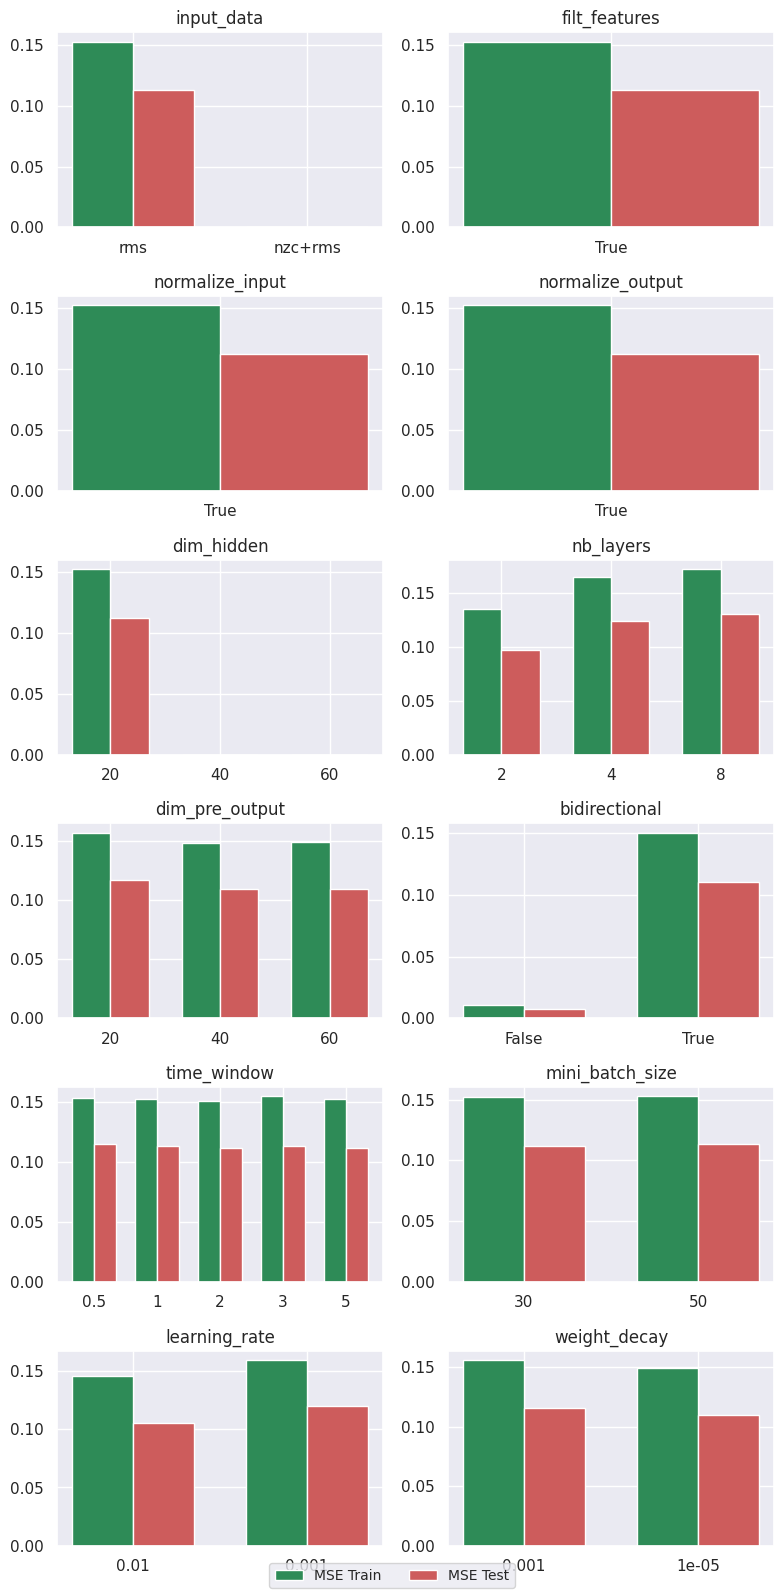

In [147]:
param_names = ['input_data', 'filt_features', 'normalize_input', 'normalize_output', 
               'dim_hidden', 'nb_layers', 'dim_pre_output', 'bidirectional', 
               'time_window', 'mini_batch_size', 'learning_rate', 'weight_decay']


fig, axes = plt.subplots(6,2,figsize=(8,16))
colors = ['seagreen','indianred']
width = 0.35

for i, ax in enumerate(axes.flat):
    ax.set_title(param_names[i])

    param_k = all_params[i]
    xval = np.arange(len(param_k))

    mse_train_k, mse_test_k, params_k = [],[],[]

    for j in range(len(param_k)):
        idx_param_j = np.where(results_grid[:,i] == param_k[j])[0]
        mse_train_j, mse_test_j, nb_params_j = results_grid[idx_param_j,-3:].T
        if len(idx_param_j) > 0:
            mse_train_j, mse_test_j, _ = results_grid[idx_param_j, -3:].T
            mse_train_k.append(np.array(mse_train_j).mean(0))
            mse_test_k.append(np.array(mse_test_j).mean(0))
        else:
            mse_train_k.append(0)
            mse_test_k.append(0)
    
    ax.bar(xval - width/2, mse_train_k, width, label='MSE Train',color=colors[0])
    ax.bar(xval + width/2, mse_test_k, width,  label='MSE Test', color=colors[1])
        
    ax.set_xticks(xval)
    ax.set_xticklabels(param_k)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize='small')

plt.tight_layout()
plt.show()

